In [1]:
import os
import copy
import numpy as np
import imageio
import matplotlib.pyplot as plt
import keras
import segmentation_models as sm
from segmentation_models import get_preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score 
import tensorflow as tf

print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}", )
print(f"TensorFlow version: {tf.__version__}")
print("Imports Done")

SEGMENTATIONS_ROOT = "Segmentations/"
IMAGES_ROOT = "Images/"
VALIDATION_ROOT = "ValidationImages/"

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Num GPUs Available: 1
TensorFlow version: 2.1.0
Imports Done


# Load Images

In [2]:
def load_feature_image(path):
    intensity_image = imageio.imread(path + "_graymap.png") / 255
    normals_image = imageio.imread(path + "_normalmap.png") / 255
    feature_image = np.dstack((intensity_image, 
                                   normals_image[:, :, 0], normals_image[:, :, 1], normals_image[:, :, 2]))
    return feature_image

def load_data() -> (np.array, np.array):
    segmentation_files = os.listdir(SEGMENTATIONS_ROOT)
    segmentations = np.array([None for i in range(len(segmentation_files))])
    datasets = np.array([None for i in range(len(segmentation_files))])
    
    for i, sf in enumerate(segmentation_files):
        data_name = '_'.join(sf.split('.')[0].split('_')[0:2])
        segmentation_image = imageio.imread(SEGMENTATIONS_ROOT + sf) 
        segmentations[i] = (1 - (segmentation_image // 255)).astype(int)
        
        datasets[i] = load_feature_image(IMAGES_ROOT + data_name)
        
    return datasets, segmentations

original_datasets, original_segmentations = load_data()
print(original_datasets[0].shape)

(182, 158, 4)


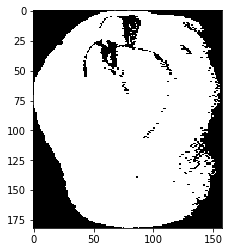

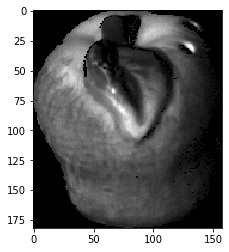

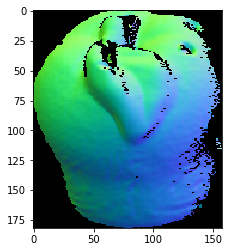

In [3]:
plt.figure()
plt.imshow(original_segmentations[0]).set_cmap('gray')
plt.figure()
plt.imshow(original_datasets[0][:, :, 0]).set_cmap('gray')
plt.figure()
plt.imshow(original_datasets[0][:, :, 1:])

# Tile Images

In [3]:
window_size = 64
step_size = 32


def tile_data(datasets, segmentations):
    tiled_datasets = np.array([])
    tiled_segmentations = np.array([])
    for i in range(len(segmentations)):
        segmentation = segmentations[i]
        dataset = datasets[i]
        tiled_s = cut_tiles(segmentation)
        tiled_d = cut_tiles(dataset)
        
        if (len(tiled_segmentations) == 0):
            tiled_datasets = tiled_d
            tiled_segmentations = tiled_s
        else:
            tiled_datasets = np.concatenate((tiled_datasets, tiled_d), axis=0)
            tiled_segmentations = np.concatenate((tiled_segmentations, tiled_s), axis=0)
        
    tiled_datasets, tiled_segmentations = delete_empty(tiled_datasets, tiled_segmentations)
    return tiled_datasets, tiled_segmentations

        
def cut_tiles(img):
    vertical_tiles = (img.shape[0] - window_size) // step_size + 1
    horizontal_tiles = (img.shape[1] - window_size) // step_size + 1
    total_tiles = vertical_tiles * horizontal_tiles
    
    if (len(img.shape) > 2):
        cutout = np.zeros((total_tiles, window_size, window_size, img.shape[2])) 
    else:
        cutout = np.zeros((total_tiles, window_size, window_size)) 
   
    index = 0
    for v_tile in range(vertical_tiles):
        for h_tile in range(horizontal_tiles):
            y_start = v_tile * step_size
            y_end = v_tile * step_size + window_size 
            x_start = h_tile * step_size
            x_end = h_tile * step_size + window_size 
            tile = img[y_start:y_end, x_start:x_end]
            cutout[index] = tile
            index += 1
    return cutout


def delete_empty(datasets, segmentations):
    count = 0
    indices = []
    for i in range(len(segmentations)):
        s = np.sum(datasets[i][:, :, 0])
        if s == 0 or s == window_size*window_size:
            indices.append(i)
    return np.delete(datasets, indices, axis=0), np.delete(segmentations, indices, axis=0)
    
    
datasets, segmentations = tile_data(original_datasets, original_segmentations)  
print(segmentations.shape)
print(datasets.shape)

(7771, 64, 64)
(7771, 64, 64, 4)


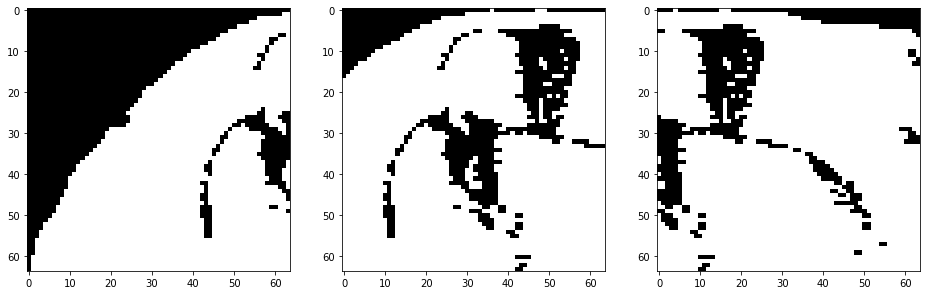

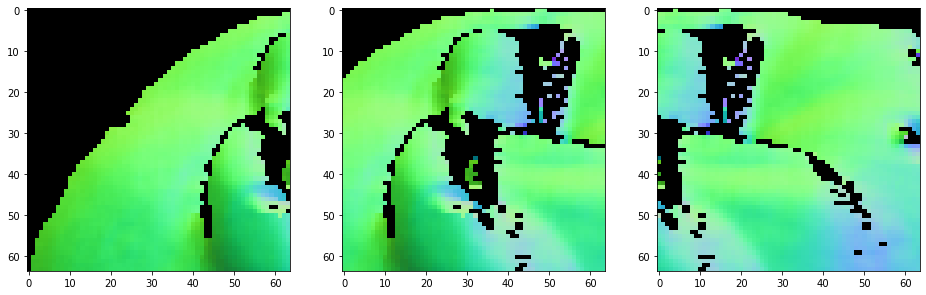

In [5]:
plt.figure(figsize=(16,16))

plt.subplot(1, 3, 1)
plt.imshow(segmentations[0]).set_cmap('gray')

plt.subplot(1, 3, 2)
plt.imshow(segmentations[1]).set_cmap('gray')

plt.subplot(1, 3, 3)
plt.imshow(segmentations[2]).set_cmap('gray')

plt.figure(figsize=(16,16))

plt.subplot(1, 3, 1)
plt.imshow(datasets[0][:, :, 1:])

plt.subplot(1, 3, 2)
plt.imshow(datasets[1][:, :, 1:])

plt.subplot(1, 3, 3)
plt.imshow(datasets[2][:, :, 1:])

# Data Augmentation

In [4]:
def add_flips(datasets, segmentations):
    flipped_datasets = np.zeros((datasets.shape[0] * 3, datasets.shape[1], datasets.shape[2], datasets.shape[3])) 
    flipped_segmentations = np.zeros((segmentations.shape[0] * 3, segmentations.shape[1], segmentations.shape[2])) 
    
    for i in range(len(segmentations)):
        j = i * 3
        flipped_datasets[j] = datasets[i]
        flipped_datasets[j + 1] = np.flip(datasets[i], 0)
        flipped_datasets[j + 2] = np.flip(datasets[i], 1)
        flipped_segmentations[j] = segmentations[i]
        flipped_segmentations[j + 1] = np.flip(segmentations[i], 0)
        flipped_segmentations[j + 2] = np.flip(segmentations[i], 1)  

    return flipped_datasets, flipped_segmentations

datasets, segmentations = add_flips(datasets, segmentations)  
print(segmentations.shape)
print(datasets.shape)

(23313, 64, 64)
(23313, 64, 64, 4)


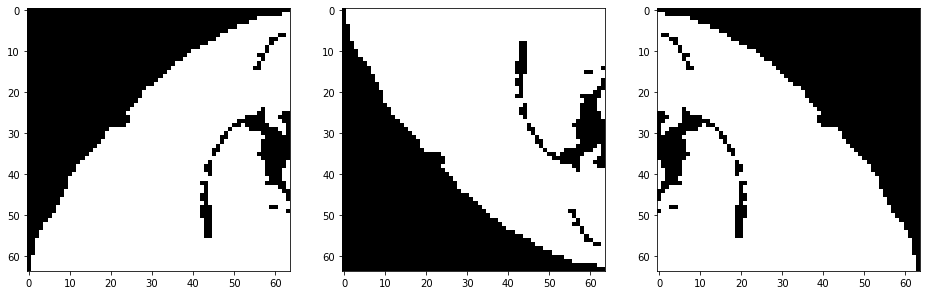

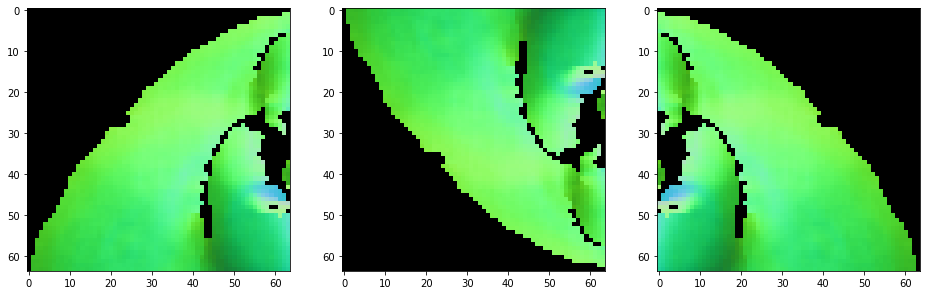

In [7]:
plt.figure(figsize=(16,16))

plt.subplot(1, 3, 1)
plt.imshow(segmentations[0]).set_cmap('gray')

plt.subplot(1, 3, 2)
plt.imshow(segmentations[1]).set_cmap('gray')

plt.subplot(1, 3, 3)
plt.imshow(segmentations[2]).set_cmap('gray')

plt.figure(figsize=(16,16))

plt.subplot(1, 3, 1)
plt.imshow(datasets[0][:, :, 1:])

plt.subplot(1, 3, 2)
plt.imshow(datasets[1][:, :, 1:])

plt.subplot(1, 3, 3)
plt.imshow(datasets[2][:, :, 1:])

# Training/Evaluation Split

In [5]:
train_datasets, eval_datasets, train_segmentations, eval_segmentations =\
train_test_split(datasets, segmentations, test_size=0.3, random_state=42)
train_segmentations = np.expand_dims(train_segmentations, axis=3)
eval_segmentations = np.expand_dims(eval_segmentations, axis=3)

print(train_datasets.shape)
print(eval_datasets.shape)
print(train_segmentations.shape)
print(eval_segmentations.shape)

(16319, 64, 64, 4)
(6994, 64, 64, 4)
(16319, 64, 64, 1)
(6994, 64, 64, 1)


# Model Training

In [6]:
unet = sm.Unet(encoder_weights=None, classes=1, input_shape=(None, None, 4))
unet.compile('Adam', loss=sm.losses.binary_crossentropy, metrics=[sm.metrics.f1_score])
print("Model Compilation Done")

c:\python\python37\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


Model Compilation Done


In [7]:
unet.load_weights('unet_weights.keras')

In [10]:
unet.fit(
    x=train_datasets,
    y=train_segmentations,
    batch_size=64,
    epochs=10,
    validation_data=(eval_datasets, eval_segmentations),
)

Train on 16319 samples, validate on 6994 samples
Epoch 1/10
16319/16319 [==============================] - 45s 3ms/step - loss: 0.1427 - f1-score: 0.9179 - val_loss: 0.1005 - val_f1-score: 0.9395
Epoch 2/10
16319/16319 [==============================] - 35s 2ms/step - loss: 0.0621 - f1-score: 0.9701 - val_loss: 0.0534 - val_f1-score: 0.9739
Epoch 3/10
16319/16319 [==============================] - 35s 2ms/step - loss: 0.0469 - f1-score: 0.9787 - val_loss: 0.0437 - val_f1-score: 0.9836
Epoch 4/10
16319/16319 [==============================] - 35s 2ms/step - loss: 0.0396 - f1-score: 0.9825 - val_loss: 0.0399 - val_f1-score: 0.9864
Epoch 5/10
16319/16319 [==============================] - 35s 2ms/step - loss: 0.0369 - f1-score: 0.9839 - val_loss: 0.0415 - val_f1-score: 0.9874
Epoch 6/10
16319/16319 [==============================] - 35s 2ms/step - loss: 0.0343 - f1-score: 0.9850 - val_loss: 0.0360 - val_f1-score: 0.9877
Epoch 7/10
16319/16319 [==============================] - 35s 2ms/ste

In [13]:
unet.save_weights('unet_weights.keras')

# Prediction

(2, 64, 64, 4)


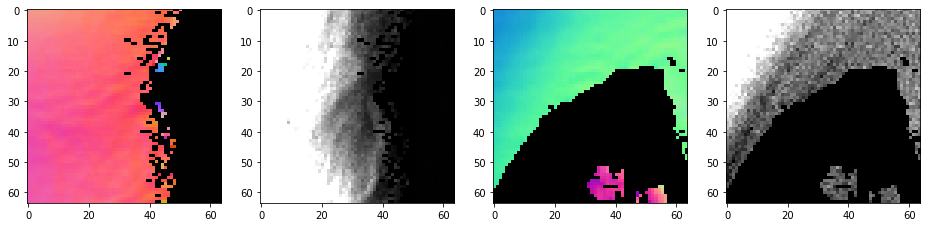

In [8]:
val_im1 = load_feature_image(VALIDATION_ROOT + "apple_13")
val_im2 = load_feature_image(VALIDATION_ROOT + "toilet_05")
val_images = np.array([val_im1, val_im2])
print(val_images.shape)

plt.figure(figsize=(16,16))
plt.subplot(1, 4, 1)
plt.imshow(val_im1[:, :, 1:])
plt.subplot(1, 4, 2)
plt.imshow(val_im1[:, :, 0]).set_cmap('gray')
plt.subplot(1, 4, 3)
plt.imshow(val_im2[:, :, 1:])
plt.subplot(1, 4, 4)
plt.imshow(val_im2[:, :, 0]).set_cmap('gray')

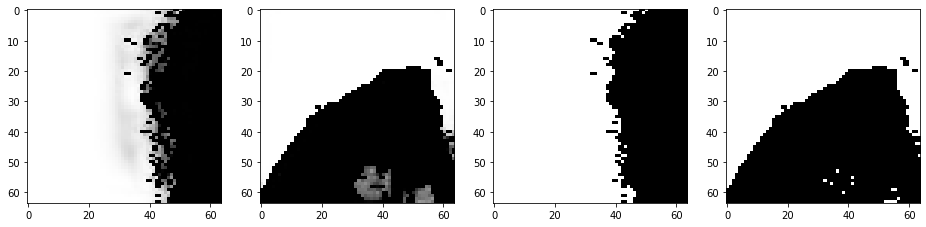

In [9]:
predictions = unet.predict(val_images)
prediction_im1, prediction_im2 = predictions[0][:, :, 0], predictions[1][:, :, 0]
threshold_im1 = prediction_im1 > np.average(prediction_im1)
threshold_im2 = prediction_im2 > np.average(prediction_im2)

plt.figure(figsize=(16,16))
plt.subplot(1, 4, 1)
plt.imshow(prediction_im1).set_cmap('gray')
plt.subplot(1, 4, 2)
plt.imshow(prediction_im2).set_cmap('gray')

plt.subplot(1, 4, 3)
plt.imshow(threshold_im1).set_cmap('gray')
plt.subplot(1, 4, 4)
plt.imshow(threshold_im2).set_cmap('gray')

# Precision and Recall

In [10]:
eval_predictions = unet.predict(eval_datasets[:5])

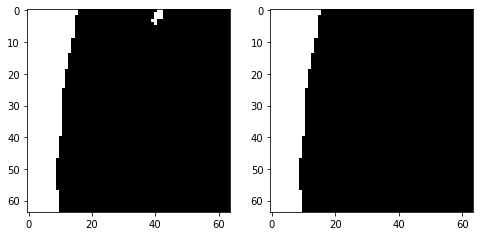

In [11]:
my_prediction = (eval_predictions[1][:, :, 0] > np.average(eval_predictions[1][:, :, 0])).astype(int)
my_segmentation = eval_segmentations[1][:, :, 0].astype(int)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.imshow(my_prediction).set_cmap('gray')
plt.subplot(1, 2, 2)
plt.imshow(my_segmentation).set_cmap('gray')

In [12]:
true_positives = np.sum(my_segmentation & my_prediction)
false_positives = np.sum(my_prediction & (1 - my_segmentation))
true_negatives = np.sum((1-my_segmentation) & (1-my_prediction))
false_negatives = np.sum(my_segmentation & (1 - my_prediction))

precision = true_positives/(true_positives + false_positives)
recall = true_positives/(true_positives + false_negatives)

print(f"Precision on one eval example: {precision}")
print(f"Recall on one eval example: {recall}")

Precision on one eval example: 0.9853333333333333
Recall on one eval example: 1.0
